<a href="https://colab.research.google.com/github/vasiliyeskin/MachineLearningExperiences/blob/master/Google_TPU/Cifar10_TPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Обучаем нейронную сеть на тензорном процессоре Google TPU
# (Исправлено создание TPU модели для TF 2.x и скрипт запуска обучения модели)

Этот ноутбук является частью учебного курса [Программирование глубоких нейронных сетей на Python](https://www.asozykin.ru/courses/nnpython).

Чтобы запускать и редактировать код, сохраните копию этого ноутбука себе (File->Save a copy in Drive...). Свою копию вы сможете изменять и запускать.

Не забудьте выбрать ускоритель TPU в меню Runtime -> Change runtime type -> Hardware accelerator -> TPU



In [38]:
import numpy as np
import tensorflow as tf
import os
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing import image
from google.colab import files
import matplotlib.pyplot as plt
%matplotlib inline 

In [39]:
# Названия классов из набора данных CIFAR-10
classes=['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

**Загружаем данные**

In [40]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

**Просмотр примеров данных**

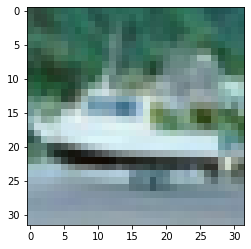

Номер класса: [8]
Тип объекта: корабль


In [41]:
n = 9555
plt.imshow(x_train[n])
plt.show()
print("Номер класса:", y_train[n])
print("Тип объекта:", classes[y_train[n][0]])

## Создаем нейронную сеть

In [42]:
def create_model():
    input_layer = Input(shape=(32, 32, 3), dtype=tf.float32, name='Input')
    x = BatchNormalization()(input_layer)
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(10, activation='softmax')(x)
    model = Model(inputs=[input_layer], outputs=[output_layer])
    model.compile(
        optimizer=tf.optimizers.Adam(0.001),
        loss=tf.keras.losses.sparse_categorical_crossentropy,
        metrics=['sparse_categorical_accuracy'])
    return model   


In [43]:
cpu_model = create_model()

**Преобразуем модель для TPU**

In [44]:
TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
TPU_WORKER

'grpc://10.79.8.242:8470'

In [45]:
print(tf.__version__)
# tf.logging.set_verbosity(tf.logging.INFO)
# tpu_model = tf.contrib.tpu.keras_to_tpu_model(
#     cpu_model,
#     strategy=tf.contrib.tpu.TPUDistributionStrategy(
#         tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))



# TF 2.x
#   @swghosh PR#4 - https://github.com/huan/tensorflow-handbook-tpu/pull/4
#
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

strategy = tf.distribute.experimental.TPUStrategy(tpu)
print("REPLICAS: ", strategy.num_replicas_in_sync)

#
# Create model with TPU strategy
#
with strategy.scope():
  tpu_model = create_model()
  tpu_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=[tf.keras.metrics.sparse_categorical_accuracy])


2.2.0
Running on TPU  ['10.79.8.242:8470']


INFO:tensorflow:Initializing the TPU system: grpc://10.79.8.242:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.79.8.242:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [46]:
tpu_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 16, 16, 32)        128 

## Обучаем нейронную сеть

In [4]:
history = tpu_model.fit(x_train.astype(np.float32), y_train.astype(np.float32),
              batch_size=256*8,
              epochs=50,
              verbose=2)

# history = tpu_model.fit(
#   x_train.astype(np.float32), y_train.astype(np.float32),
#   epochs=50,
#   steps_per_epoch=60,
#   validation_data=(x_test.astype(np.float32), y_test.astype(np.float32)),
#   validation_freq=5
# )

NameError: ignored

## Оцениваем качетсво обучения сети

In [24]:
# Оцениваем качество обучения модели на тестовых данных
scores = tpu_model.evaluate(x_test.astype(np.float32), y_test.astype(np.float32), verbose=0, batch_size=256 * 8)
print("Доля верных ответов на тестовых данных: %.2f%%" % (scores[1]*100))

Доля верных ответов на тестовых данных: 82.29%


## Сохраняем обученную нейронную сеть

In [25]:
tpu_model.save_weights("cifar10_model.h5")

In [26]:
!ls

cifar10_model.h5  sample_data


Скачиваем обученные веса на свой компьютер

In [ ]:
files.download("cifar10_model.h5")

## Применяем сеть для распознавания объектов на CPU

Создаем модель на CPU и загружаем веса в нее

In [16]:
model = create_model()
model.load_weights("cifar10_model.h5")

In [27]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 16, 16, 32)        128 

**Просмотр изображения из набора данных для тестирования**

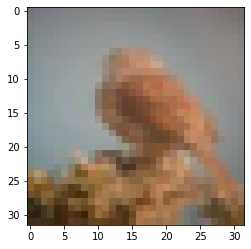

In [34]:
index=113
plt.imshow(x_test[index])
plt.show()

**Преобразование тестового изображения**

In [35]:
x = x_test[index]
x = np.expand_dims(x, axis=0)

**Запуск распознавания**

In [36]:
prediction = model.predict(x)

**Печатаем результаты распознавания**

In [37]:
print(prediction)
prediction = np.argmax(prediction)
print(classes[prediction])

[[7.7547874e-08 6.5297399e-11 9.9882513e-01 2.2148988e-05 2.9799377e-05
  2.5220268e-05 1.0939373e-03 3.6750589e-06 1.8347285e-08 1.6028101e-09]]
птица


In [33]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         108G   32G   71G  31% /
tmpfs            64M     0   64M   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
shm             5.9G     0  5.9G   0% /dev/shm
tmpfs           6.4G   12K  6.4G   1% /var/colab
/dev/sda1       114G   33G   82G  29% /etc/hosts
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware


## Полезные ссылки

1. Документация по TPU - https://cloud.google.com/tpu/
2. Использование TPU в облаке Google - https://cloud.google.com/tpu/docs/tpus
3. Пример использования Keras с TPU от Франсуа Шоле - https://colab.research.google.com/github/tensorflow/tpu/blob/master/tools/colab/fashion_mnist.ipynb#scrollTo=W7gMbs70GxA7